In [1]:
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D
from tensorflow.keras import regularizers
from pathlib import Path
from tensorflow import keras
from livelossplot.inputs.keras import PlotLossesCallback
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pickle

In [2]:
batch_size = 2
#train= tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.2, 
#                                                       zoom_range=0.2, 
#                                                       horizontal_flip=True,
#                                                       fill_mode="nearest",
#                                                       rotation_range=25,
#                                                       preprocessing_function=preprocess_input)

train= tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.2, rotation_range=90, 
                                                     width_shift_range=0.5, 
                                                     height_shift_range=0.5,
                                                     zoom_range=0.2,
                                                    horizontal_flip=True, 
                                                     vertical_flip=True,
                                                     preprocessing_function=preprocess_input)


test= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

In [3]:
traingen = train.flow_from_directory(directory="train",
                                        target_size=(224,224), 
                                        class_mode='categorical',
                                        shuffle= True,
                                        )

Found 6005 images belonging to 102 classes.


In [4]:
validgen = test.flow_from_directory(directory="val", 
                                   target_size=(224,224), 
                                   class_mode='categorical',
                                    shuffle= True,
                                    )

Found 1019 images belonging to 102 classes.


In [5]:
dit ="image_00070.jpg"
pic = load_img(dit)
pic_array = img_to_array(pic)
pic_array = pic_array.reshape((1, )+ pic_array.shape)
pic_array.shape

(1, 500, 667, 3)

count = 0
for batch in train.flow(pic_array, batch_size = 1, save_to_dir = "image_traingen", save_prefix= 'flower', save_format='jpeg'):
    count +=1
    if count >35:
        break

In [6]:
kernel_regularizer1 = tf.keras.regularizers.l1(0.01)
activity_regularizer2 = tf.keras.regularizers.l2(0.01)

In [7]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    print("optimizer: ", optimizer)
    vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))
    
    if fine_tune > 0:
        for layer in vgg_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in vgg_model.layers:
            layer.trainable = False
            
            
    top_model = vgg_model.output
    #top_model = Dropout(0.5)(top_model)
    top_model = AveragePooling2D(pool_size=(4, 4))(top_model)
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.001))(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001))(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.001))(top_model)
    
    #-------------------------------------------------#
    model = Model(inputs=vgg_model.input, outputs=output_layer)
    #model.layers[22].trainable = False
    
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    

In [8]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.0001, decay=0.0001/100)
n_classes=102

n_steps = len(traingen)//batch_size
n_val_steps = len(validgen)//batch_size
n_epochs = 300

# First we'll train the model without Fine-tuning
vgg16_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

optimizer:  <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x0000022ED3CA9610>


In [9]:

vgg16_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [10]:
for i,layer in enumerate(vgg16_model.layers):
    print(i,layer.name," : " ,layer.trainable)

0 input_1  :  False
1 block1_conv1  :  False
2 block1_conv2  :  False
3 block1_pool  :  False
4 block2_conv1  :  False
5 block2_conv2  :  False
6 block2_pool  :  False
7 block3_conv1  :  False
8 block3_conv2  :  False
9 block3_conv3  :  False
10 block3_pool  :  False
11 block4_conv1  :  False
12 block4_conv2  :  False
13 block4_conv3  :  False
14 block4_pool  :  False
15 block5_conv1  :  True
16 block5_conv2  :  True
17 block5_conv3  :  True
18 block5_pool  :  True
19 average_pooling2d  :  True
20 flatten  :  True
21 dense  :  True
22 dropout  :  True
23 dense_1  :  True
24 dropout_1  :  True
25 dense_2  :  True


In [11]:


plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='VGG16_re_fun3.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

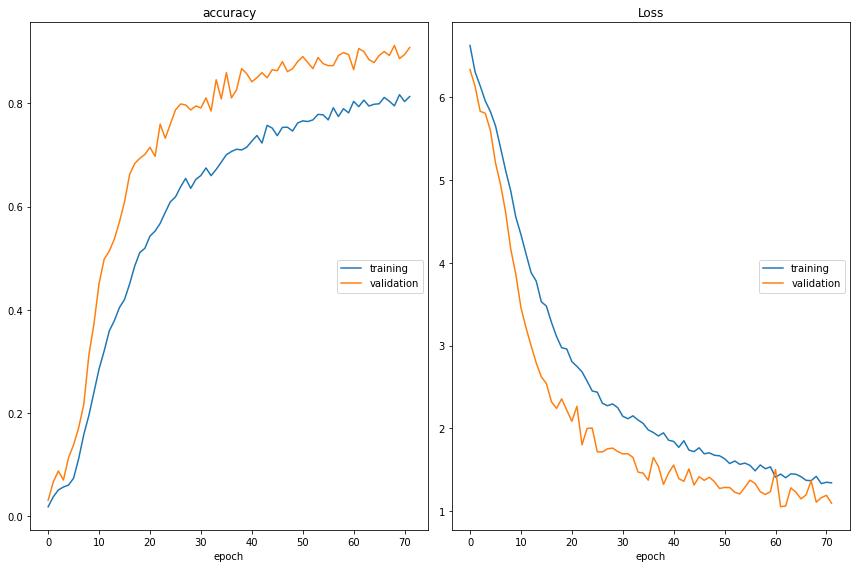

accuracy
	training         	 (min:    0.019, max:    0.817, cur:    0.813)
	validation       	 (min:    0.031, max:    0.912, cur:    0.908)
Loss
	training         	 (min:    1.333, max:    6.627, cur:    1.343)
	validation       	 (min:    1.054, max:    6.336, cur:    1.097)
94/94 [==============================] - 67s 711ms/step - loss: 1.3427 - accuracy: 0.8131 - val_loss: 1.0966 - val_accuracy: 0.9082


In [12]:
#vgg16_model.load_weights('4096-512.hdf5')
vgg_history = vgg16_model.fit(traingen,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            )

In [13]:
acc = vgg_history.history['accuracy']
val_acc = vgg_history.history['val_accuracy']

loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']

In [14]:
np.mean(val_acc[-40:])

0.8708984375

In [15]:
np.mean(acc[-30:])

0.779518085718155

In [16]:
testgen = test.flow_from_directory(directory="test", 
                                   target_size=(224,224), 
                                   class_mode='categorical',
                                    )

Found 1165 images belonging to 102 classes.


In [17]:
#vgg16_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights
#vgg16_model.load_weights('4096-512.hdf5')
#vgg16_model.load_weights('VGG16_re_fun.hdf5')
#vgg16_model.load_weights('VGG16_re_fun2.hdf5') #only one dense

In [18]:
results = vgg16_model.evaluate(testgen)

37/37 [==============================] - 12s 332ms/step - loss: 1.2742 - accuracy: 0.8876


# predict

In [19]:
dataset_test ="test"
test_dir = Path(dataset_test)
test_data_image = list(test_dir.glob('*/*.jpg'))

In [20]:
a_file = open("data_array.pkl", "rb")
class_names = pickle.load(a_file)

In [21]:
class_names[7]

'13'

In [22]:
a_file1 = open("data.pkl", "rb")
flower_dict = pickle.load(a_file1)

In [23]:

for img_path in test_data_image:
    img = keras.preprocessing.image.load_img( img_path, target_size=(224,224) )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    prediction = vgg16_model.predict(img_array)
    #print("------prediction-------")
    #print(prediction)
    #print("------prediction[0]-------")
    #print(prediction[0])
    score = tf.nn.softmax(prediction[0])
    #print("------------score---------")
    index = class_names[np.argmax(score)]
    int_index = int(index)
    print(img_path, ' : ', class_names[np.argmax(score)] ,' : ',flower_dict[int_index])
    #print(class_names[np.argmax(score)], " with ", 100 * np.max(score))

test\1\image_06744.jpg  :  1  :  pink primrose
test\1\image_06755.jpg  :  1  :  pink primrose
test\1\image_06757.jpg  :  1  :  pink primrose
test\1\image_06768.jpg  :  19  :  balloon flower
test\1\image_06770.jpg  :  34  :  mexican aster
test\1\image_06773.jpg  :  1  :  pink primrose
test\10\image_07096.jpg  :  10  :  globe thistle
test\10\image_07107.jpg  :  10  :  globe thistle
test\10\image_07109.jpg  :  10  :  globe thistle
test\10\image_07120.jpg  :  10  :  globe thistle
test\10\image_07122.jpg  :  10  :  globe thistle
test\10\image_08090.jpg  :  10  :  globe thistle
test\10\image_08092.jpg  :  10  :  globe thistle
test\100\image_07903.jpg  :  33  :  love in the mist
test\100\image_07916.jpg  :  17  :  purple coneflower
test\100\image_07927.jpg  :  33  :  love in the mist
test\100\image_07929.jpg  :  30  :  sweet william
test\100\image_07930.jpg  :  33  :  love in the mist
test\100\image_07932.jpg  :  66  :  osteospermum
test\100\image_07938.jpg  :  33  :  love in the mist
test\10

test\24\image_08051.jpg  :  92  :  bee balm
test\25\image_06581.jpg  :  101  :  trumpet creeper
test\25\image_06592.jpg  :  25  :  grape hyacinth
test\25\image_06594.jpg  :  58  :  geranium
test\25\image_06605.jpg  :  24  :  red ginger
test\25\image_06607.jpg  :  101  :  trumpet creeper
test\25\image_06610.jpg  :  94  :  foxglove
test\26\image_06497.jpg  :  55  :  pelargonium
test\26\image_06508.jpg  :  55  :  pelargonium
test\26\image_06510.jpg  :  68  :  bearded iris
test\26\image_06521.jpg  :  55  :  pelargonium
test\26\image_06523.jpg  :  3  :  canterbury bells
test\26\image_06526.jpg  :  28  :  stemless gentian
test\27\image_06860.jpg  :  33  :  love in the mist
test\27\image_06871.jpg  :  68  :  bearded iris
test\27\image_06873.jpg  :  68  :  bearded iris
test\27\image_06884.jpg  :  22  :  pincushion flower
test\27\image_06886.jpg  :  68  :  bearded iris
test\27\image_06889.jpg  :  68  :  bearded iris
test\28\image_05231.jpg  :  101  :  trumpet creeper
test\28\image_05233.jpg  : 

test\42\image_05721.jpg  :  68  :  bearded iris
test\42\image_05722.jpg  :  28  :  stemless gentian
test\42\image_05724.jpg  :  3  :  canterbury bells
test\42\image_05730.jpg  :  98  :  mexican petunia
test\42\image_05731.jpg  :  67  :  spring crocus
test\42\image_05734.jpg  :  28  :  stemless gentian
test\43\image_02329.jpg  :  43  :  sword lily
test\43\image_02342.jpg  :  3  :  canterbury bells
test\43\image_02355.jpg  :  33  :  love in the mist
test\43\image_02358.jpg  :  3  :  canterbury bells
test\43\image_02362.jpg  :  43  :  sword lily
test\43\image_02365.jpg  :  43  :  sword lily
test\43\image_02366.jpg  :  68  :  bearded iris
test\43\image_02370.jpg  :  28  :  stemless gentian
test\43\image_02397.jpg  :  3  :  canterbury bells
test\43\image_02400.jpg  :  28  :  stemless gentian
test\43\image_02401.jpg  :  68  :  bearded iris
test\43\image_02405.jpg  :  68  :  bearded iris
test\43\image_02409.jpg  :  88  :  cyclamen 
test\43\image_02413.jpg  :  3  :  canterbury bells
test\43\im

test\53\image_03709.jpg  :  68  :  bearded iris
test\53\image_03714.jpg  :  32  :  garden phlox
test\53\image_03715.jpg  :  95  :  bougainvillea
test\53\image_03720.jpg  :  76  :  morning glory
test\53\image_03722.jpg  :  82  :  clematis
test\53\image_03730.jpg  :  45  :  bolero deep blue
test\53\image_03731.jpg  :  53  :  primula
test\54\image_05409.jpg  :  41  :  barbeton daisy
test\54\image_05422.jpg  :  33  :  love in the mist
test\54\image_05433.jpg  :  54  :  sunflower
test\54\image_05435.jpg  :  33  :  love in the mist
test\54\image_05436.jpg  :  35  :  alpine sea holly
test\54\image_05438.jpg  :  54  :  sunflower
test\54\image_05444.jpg  :  54  :  sunflower
test\54\image_05445.jpg  :  66  :  osteospermum
test\54\image_05458.jpg  :  10  :  globe thistle
test\55\image_04709.jpg  :  55  :  pelargonium
test\55\image_04717.jpg  :  34  :  mexican aster
test\55\image_04735.jpg  :  92  :  bee balm
test\55\image_04738.jpg  :  55  :  pelargonium
test\55\image_04740.jpg  :  55  :  pelargo

test\69\image_05996.jpg  :  84  :  columbine
test\69\image_06002.jpg  :  62  :  japanese anemone
test\69\image_06003.jpg  :  77  :  passion flower
test\7\image_07210.jpg  :  7  :  moon orchid
test\7\image_07221.jpg  :  4  :  sweet pea
test\7\image_07223.jpg  :  7  :  moon orchid
test\7\image_08099.jpg  :  7  :  moon orchid
test\7\image_08101.jpg  :  4  :  sweet pea
test\7\image_08104.jpg  :  7  :  moon orchid
test\70\image_05288.jpg  :  70  :  tree poppy
test\70\image_05301.jpg  :  70  :  tree poppy
test\70\image_05312.jpg  :  70  :  tree poppy
test\70\image_05314.jpg  :  22  :  pincushion flower
test\70\image_05315.jpg  :  70  :  tree poppy
test\70\image_05317.jpg  :  70  :  tree poppy
test\70\image_05323.jpg  :  70  :  tree poppy
test\70\image_05324.jpg  :  68  :  bearded iris
test\70\image_05337.jpg  :  68  :  bearded iris
test\71\image_04502.jpg  :  81  :  frangipani
test\71\image_04507.jpg  :  52  :  wild pansy
test\71\image_04520.jpg  :  33  :  love in the mist
test\71\image_0452

test\78\image_01963.jpg  :  78  :  lotus
test\79\image_06703.jpg  :  79  :  toad lily
test\79\image_06714.jpg  :  79  :  toad lily
test\79\image_06716.jpg  :  79  :  toad lily
test\79\image_06727.jpg  :  79  :  toad lily
test\79\image_06729.jpg  :  79  :  toad lily
test\79\image_06732.jpg  :  79  :  toad lily
test\8\image_03305.jpg  :  8  :  bird of paradise
test\8\image_03310.jpg  :  8  :  bird of paradise
test\8\image_03323.jpg  :  8  :  bird of paradise
test\8\image_03326.jpg  :  8  :  bird of paradise
test\8\image_03330.jpg  :  77  :  passion flower
test\8\image_03333.jpg  :  8  :  bird of paradise
test\8\image_03334.jpg  :  8  :  bird of paradise
test\8\image_03352.jpg  :  8  :  bird of paradise
test\8\image_03357.jpg  :  8  :  bird of paradise
test\8\image_03358.jpg  :  8  :  bird of paradise
test\8\image_03363.jpg  :  93  :  ball moss
test\8\image_03366.jpg  :  8  :  bird of paradise
test\80\image_01985.jpg  :  19  :  balloon flower
test\80\image_02003.jpg  :  19  :  balloon flo

test\9\image_06405.jpg  :  4  :  sweet pea
test\9\image_06416.jpg  :  101  :  trumpet creeper
test\9\image_06418.jpg  :  101  :  trumpet creeper
test\9\image_06429.jpg  :  40  :  lenten rose
test\9\image_06431.jpg  :  68  :  bearded iris
test\9\image_06432.jpg  :  4  :  sweet pea
test\9\image_06434.jpg  :  4  :  sweet pea
test\90\image_04422.jpg  :  94  :  foxglove
test\90\image_04427.jpg  :  28  :  stemless gentian
test\90\image_04440.jpg  :  28  :  stemless gentian
test\90\image_04443.jpg  :  28  :  stemless gentian
test\90\image_04447.jpg  :  45  :  bolero deep blue
test\90\image_04450.jpg  :  68  :  bearded iris
test\90\image_04451.jpg  :  68  :  bearded iris
test\90\image_04469.jpg  :  28  :  stemless gentian
test\90\image_04474.jpg  :  45  :  bolero deep blue
test\90\image_04475.jpg  :  28  :  stemless gentian
test\90\image_04480.jpg  :  55  :  pelargonium
test\90\image_07300.jpg  :  28  :  stemless gentian
test\91\image_04850.jpg  :  52  :  wild pansy
test\91\image_04855.jpg  : 

# Summary 

## To do 1
- Dense 4096
- Dense 512 (1072)
dataset shuffle
- accuracy 84%
- Val_accuracy 87%

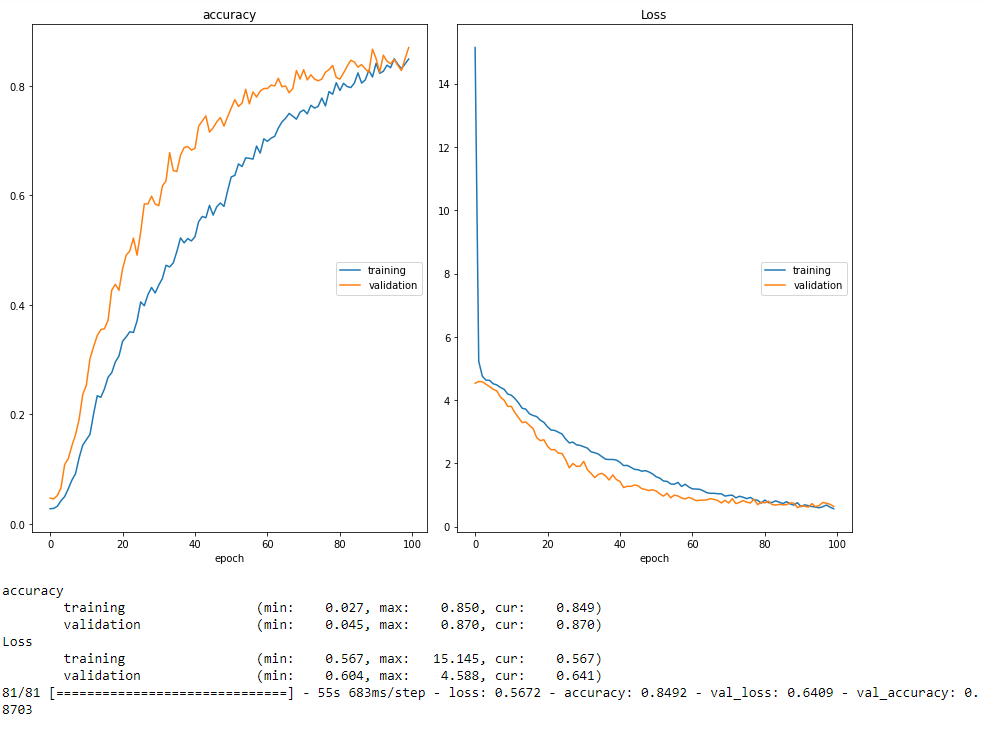


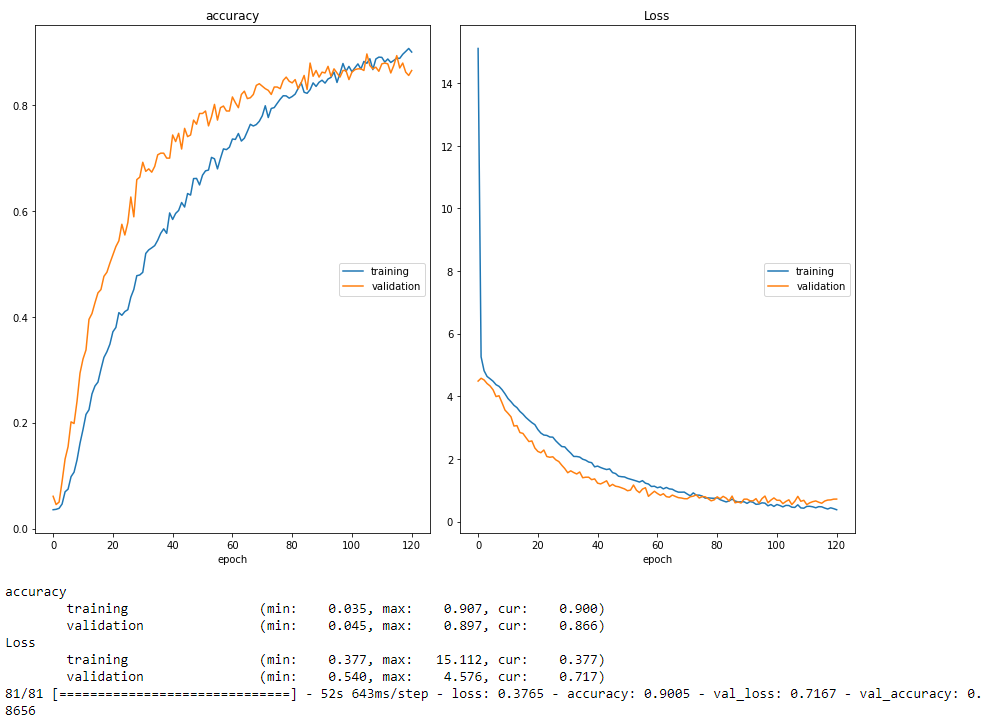

## To do 2


### Dense 512
- accuracy > 99%
- Val_accuracy > 84% 
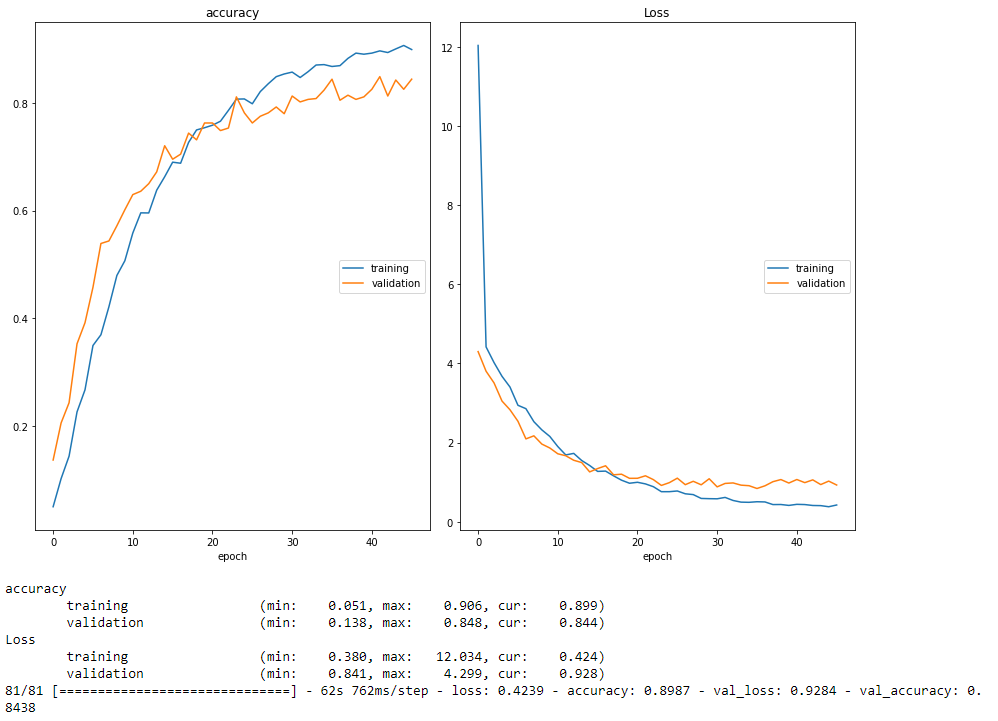
### Dense 512 + 512 

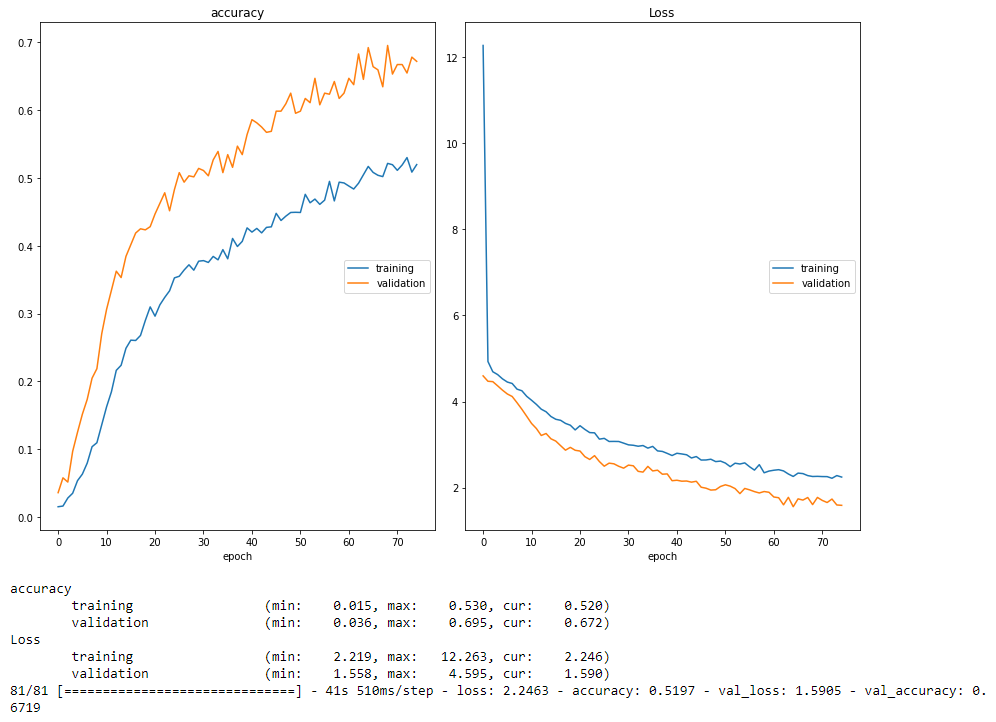


### Dense 512 + 256 
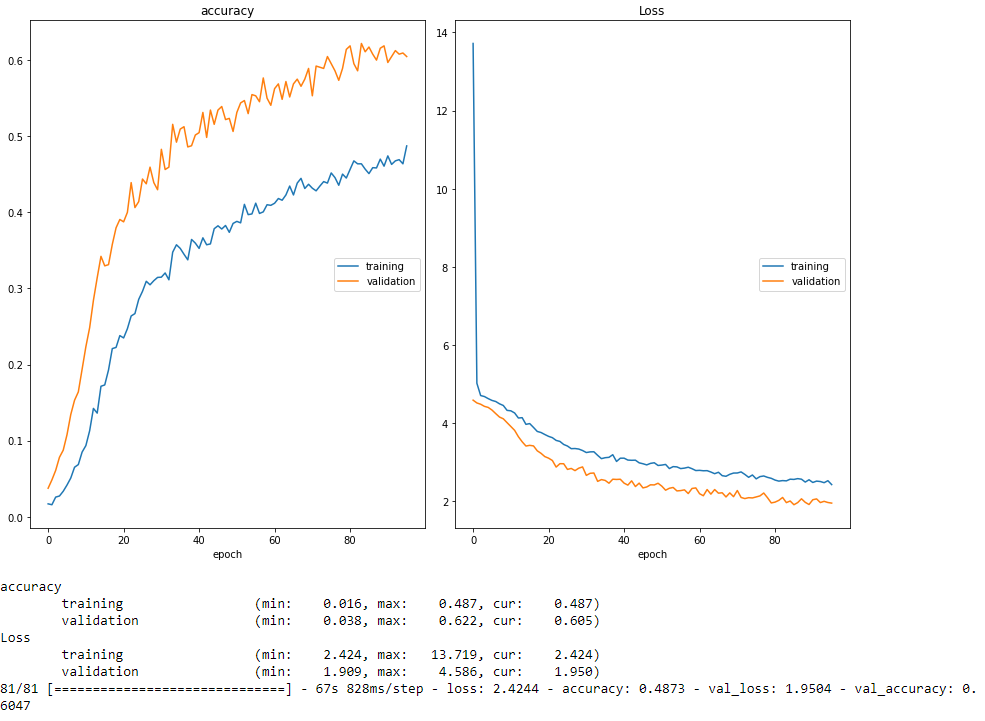

### Dense 256 

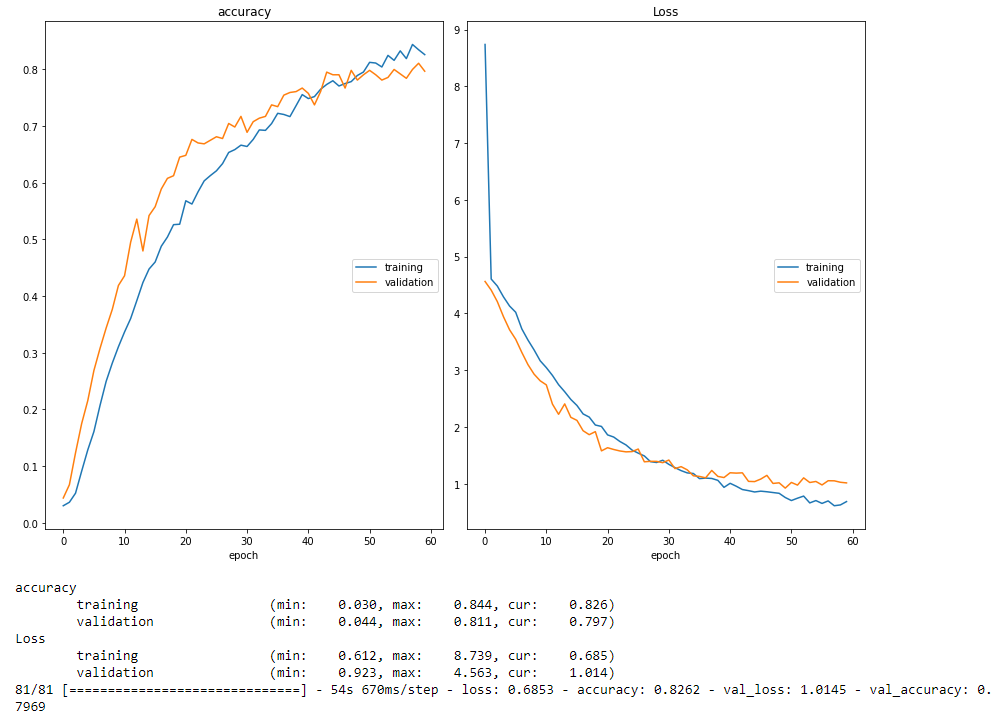

## To do 3
reduce trainable to around 1~5m

## To do 4
- increase complexity data augmentation
- change processing_input
- Dense 512 x1
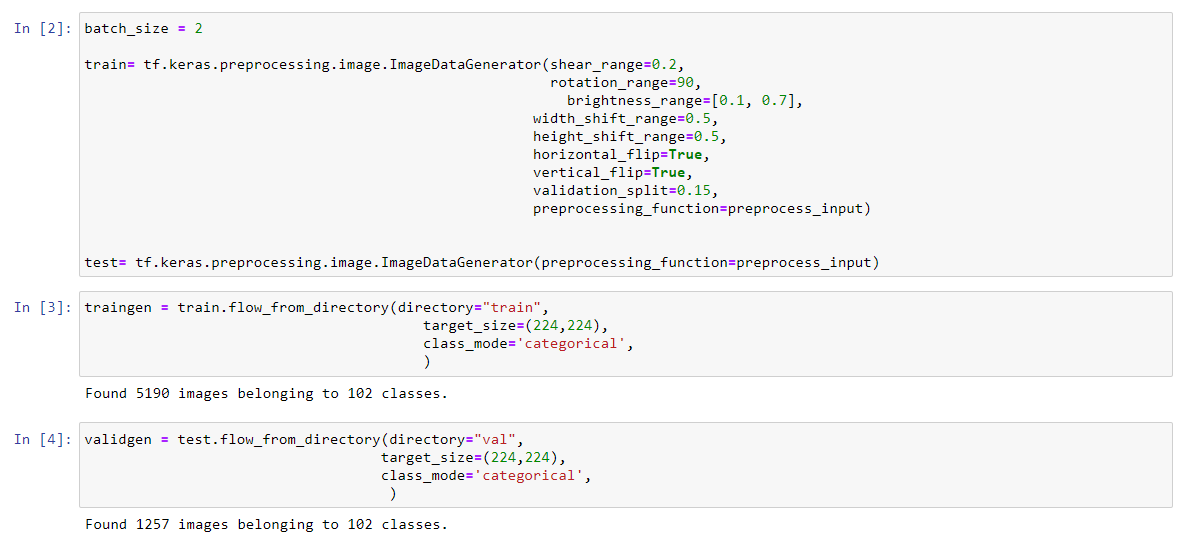


## result:
### epoches = 100
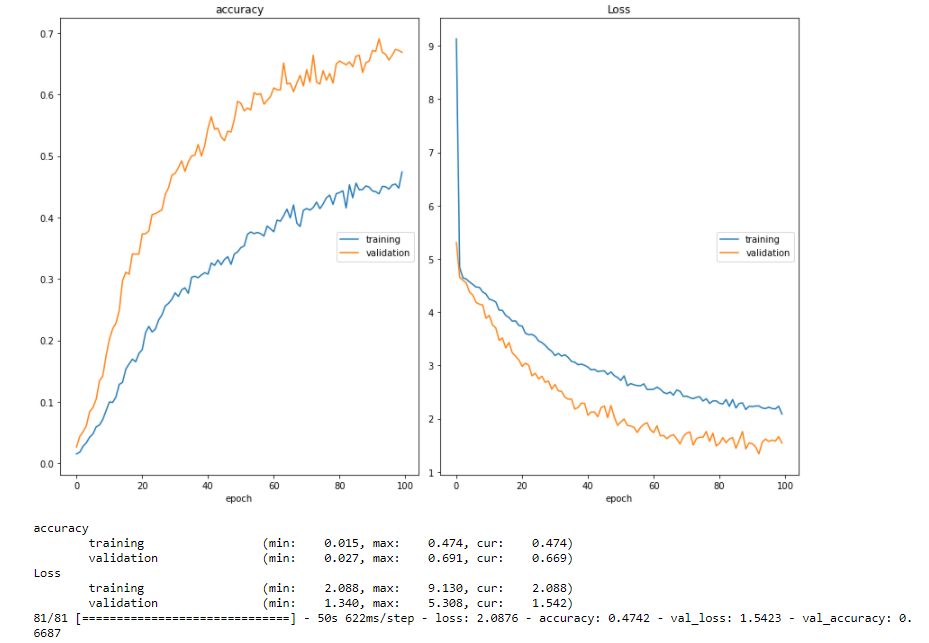

#### accuracy could be enhanced more ==> add more epoches 

### new augmentation

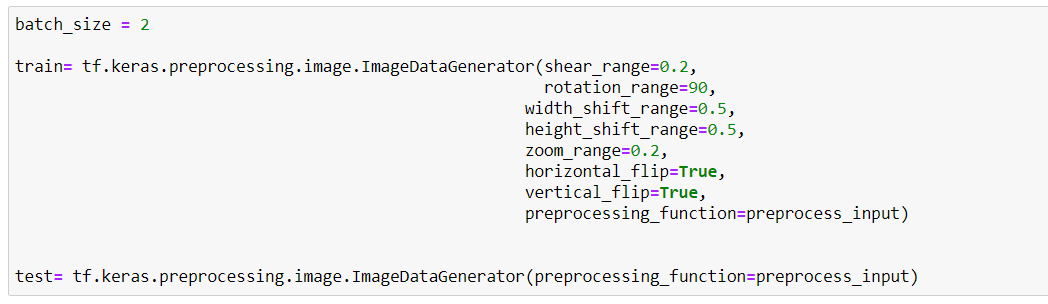

#### result
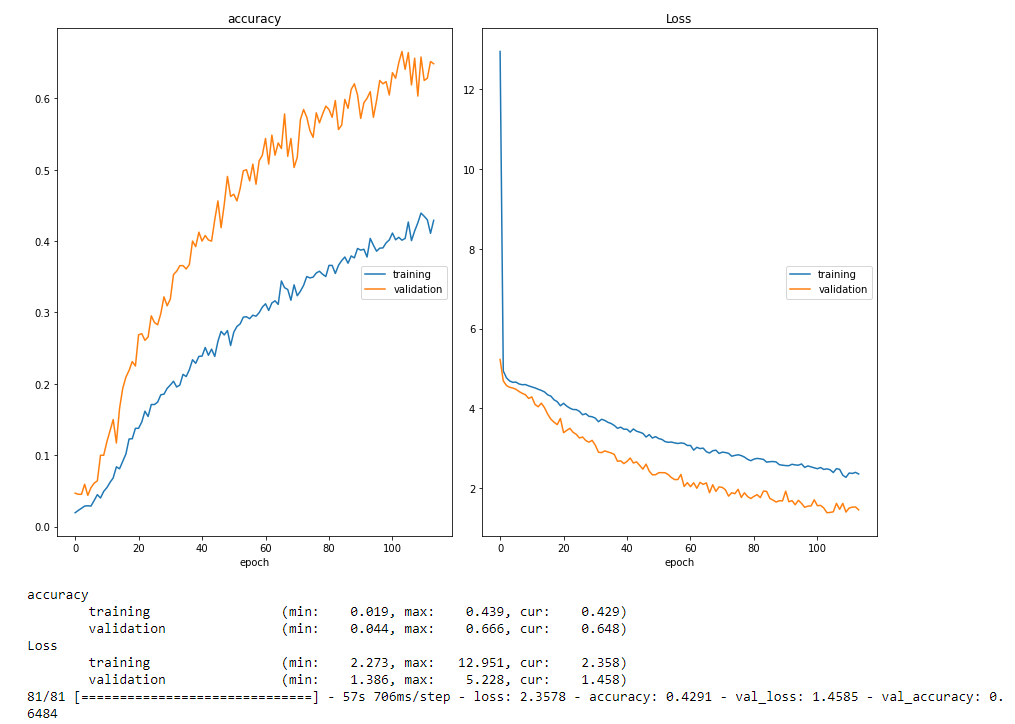


# DATA sET 1

# regularize + finite
- 4096 + 512 || val_acc: between 90% to 94%

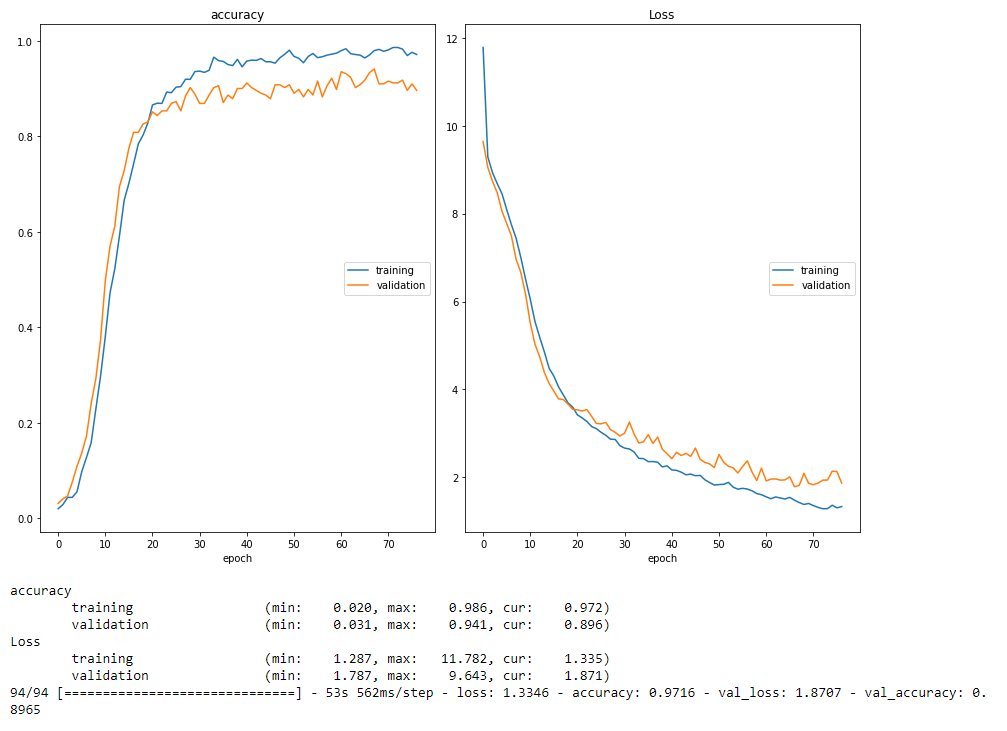
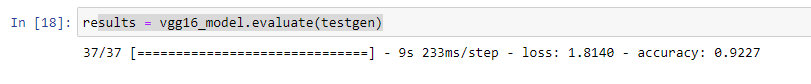

# without finite
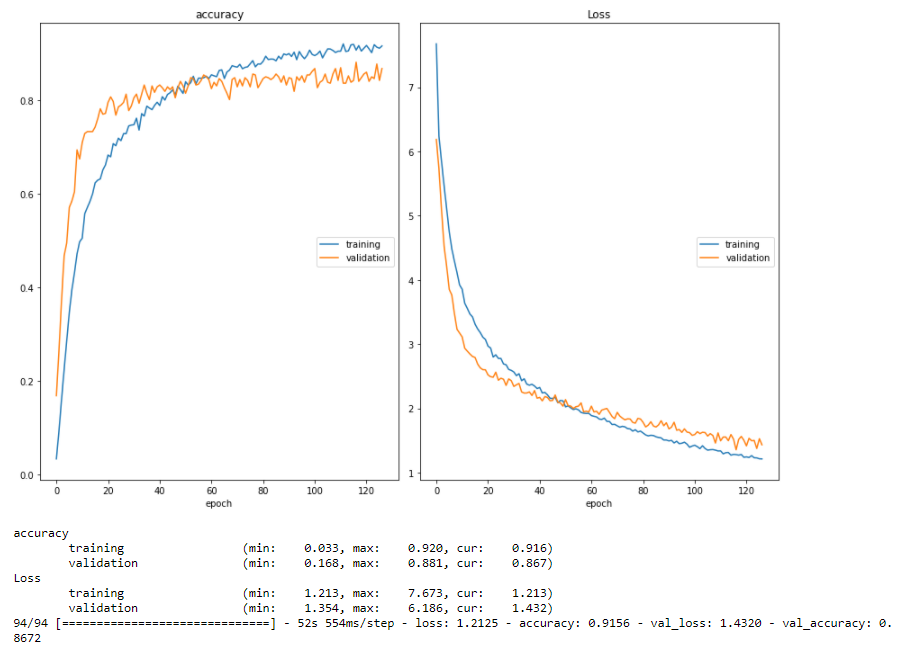
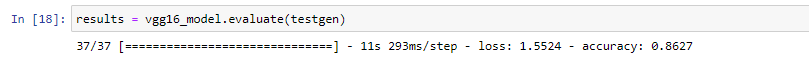

# Data Set 2

# No fine tunning

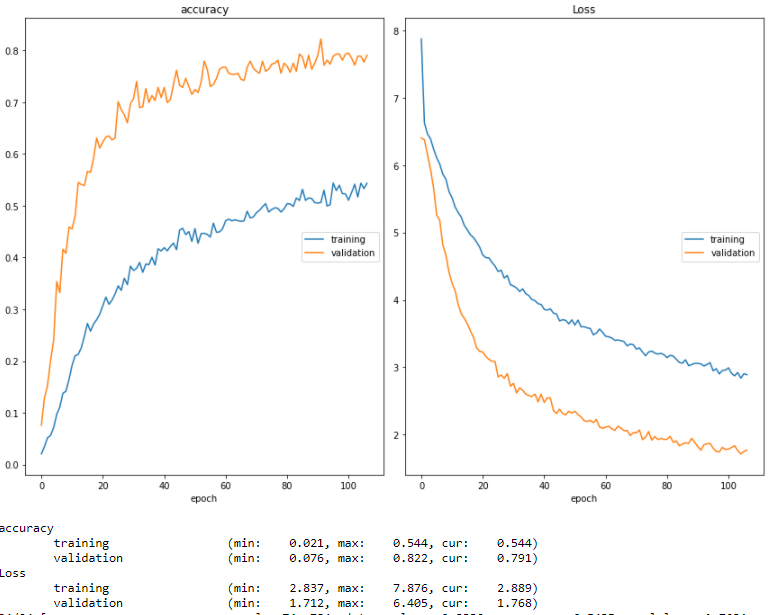

# Fine tunning
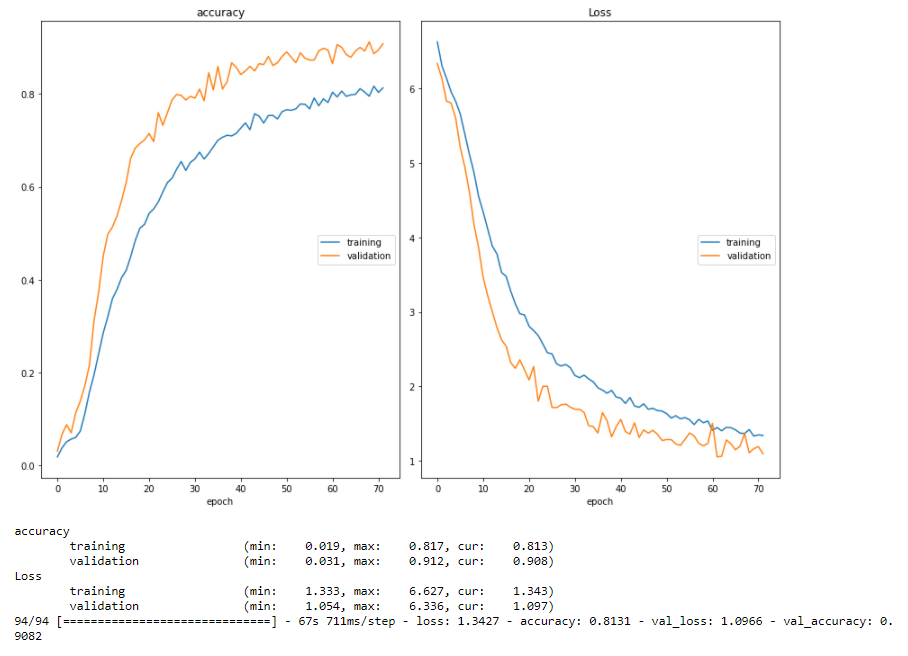